In [ ]:
# Socio-Demographic Determinants of the Better-than-Average Effect in the Context of Pro-Environmental Behavior
# post-hoc analysis for https://doi.org/10.1016/j.spc.2021.05.008

### setup

In [1]:
%%capture
!pip install factor-analyzer

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import random, math, scipy
from scipy import stats
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, preprocessing
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)
from factor_analyzer import FactorAnalyzer
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
def bootstrap(data, n=1000, func=np.mean, p=0.95, seed=13):
    random.seed(seed)
    np.random.seed(seed)
    sample_size = len(data)
    simulations = [func(np.random.choice(data, size=sample_size, replace=True)) for i in range(n)]
    simulations.sort()
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    m = func(data)
    return (m, (simulations[u_indx] - simulations[l_indx]) / 2)

def cohen_r(p, n):
    # https://www.researchgate.net/publication/51554230_Effect_Size_Estimates_Current_Use_Calculations_and_Interpretation
    # Fritz, C. O., Morris, P. E., & Richler, J. J. (2012). Effect size estimates: Current use, calculations, and interpretation. Journal of Experimental Psychology: General, 141(1), 2–18. https://doi.org/10.1037/a0024338
    # the r proposed by Cohen (1988);Cohen’s guidelines for r are that 
    # a large effect is .5, a medium effect is .3, and a small effect is .1 
    # (Coolican, 2009, p. 395).
    # Cohen’s r (Fritz et al., 2012; Cohen 1988) for Wilcoxon test is reported.
    return abs(scipy.stats.norm.ppf(p/2)) / math.sqrt(n) 

def cohen_r_t(t, df):
    # https://www.researchgate.net/publication/51554230_Effect_Size_Estimates_Current_Use_Calculations_and_Interpretation
    return math.sqrt(t**2 / (t**2 + df)) 

def cohen_d(f):
    # https://www.researchgate.net/publication/51554230_Effect_Size_Estimates_Current_Use_Calculations_and_Interpretation
    # https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00863/full
    # Cohen’s d derived from F statistic (Fritz et al., 2012)
    eta_sq = (f.fvalue * f.df_num) / ((f.fvalue * f.df_num) + f.df_denom)
    d = 2 * math.sqrt(eta_sq) / math.sqrt(1 - eta_sq)
    return d

def spearmanCI(r, n):
  stderr = 1.0 / math.sqrt(n - 3)
  delta = 1.96 * stderr
  lower = math.tanh(math.atanh(r) - delta)
  upper = math.tanh(math.atanh(r) + delta)
  return lower, upper

def plot_ecdf(data, label=''):
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.ecdfplot(data = data, legend = data)
    plt.xlabel(label)
    plt.ylabel("ECDF")
    plt.show()

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.
    This function creates a RadarAxes projection and registers it.
    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):
        name = 'radar'
        PolarTransform = RadarTransform
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)
    register_projection(RadarAxes)
    return theta

def get_stars(p):
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    if p < 0.10:
        return ''
    return ''

def get_APA(ols, sig=False): #R^2=.34, F(1,416)=6.71, p=.009
  r_sq = f'{ols.rsquared:.2f}'[1:]
  df_m = int(ols.df_model)
  df_r = int(ols.df_resid)
  f_v = f'{ols.fvalue:.2f}'[1:] if ols.fvalue < 1 else f'{ols.fvalue:.2f}'
  p_v = f'{ols.f_pvalue:.3f}'[1:] if ols.f_pvalue >= 0.001 else '.001'
  lvl = '<' if ols.f_pvalue < 0.001 else '='
  sig = get_stars(ols.f_pvalue) if sig else ''
  return f"R²={r_sq}, F({df_m}, {df_r})={f_v}, p{lvl}{p_v}{sig}"

def tree_graph(r, title, robust=True):
    def addlabels(x, y, sig):
      for i, j in enumerate(x):
          if j < 0:
            j -= 0.1
          else:
            j += 0.05
          plt.text(j, y[i], sig[i])
    rb = '_robust' if robust else ''
    d = r[pd.notna(r['sig'+rb])]# & (r['sig'+rb] != '')]
    x1 = d[d['coef'+rb] < 0]['coef'+rb].to_list()
    sig1 = d[d['coef'+rb] < 0]['sig'+rb].to_list()
    x2 = d[d['coef'+rb] > 0]['coef'+rb].to_list()
    sig2 = d[d['coef'+rb] > 0]['sig'+rb].to_list()
    y1 = range(len(x1))
    y2 = range(len(x1), (len(x1) + len(x2))) 
    y = range(len(x1) + len(x2))
    yl1 = d[d['coef'+rb] < 0].feature.to_list()
    yl2 = d[d['coef'+rb] > 0].feature.to_list()
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(5, 3.5))
    bar1 = axes[0].barh(y1, x1, align='center', color='red')
    bar2 = axes[1].barh(y2, x2, align='center', color='blue')
    axes[0].set(yticks=y, yticklabels=yl1 + yl2)
    axes[0].set_xlim([-1, -0.001])
    axes[1].set_xlim([0.001, 1])
    for ax in axes.flat:
        ax.margins(0.03)
        ax.grid(True)
    for i, b in enumerate(bar1):
        if len(sig1[i]):
          b.set_color('mediumorchid')
        else:
          b.set_color('thistle')
    for i, b in enumerate(bar2):
        if len(sig2[i]):
          b.set_color('mediumorchid')
        else:
          b.set_color('thistle')
    addlabels(x1, y1, sig1)
    addlabels(x2, y2, sig2)
    axes[0].tick_params(axis='y', which='both', labelleft=True, labelright=False)
    axes[1].tick_params(axis='y', which='both', labelleft=False, labelright=False)
    fig.suptitle(title, y=1.05)
    fig.text(0.5, 0, 'Стандартизованный коэффициент β', ha='center')
    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, top=0.93)
    plt.show()
    return fig

def calc_OLS(data, x, y, standardized=True):
    _d = data
    if standardized:
      scaler = StandardScaler()
      scaler.fit(_d)
      __d = scaler.transform(_d)
      __d=pd.DataFrame(__d)
      __d.columns = _d.columns
      _d = __d
    f = f'{y} ~ 1 + ' + '+'.join([i for i in x if i in _d])
    #print(f)
    ols = smf.ols(f, _d).fit(cov_type='HC1')
    #print(ols.summary())
    robust = smf.rlm(f, _d, M=sm.robust.norms.HuberT()).fit() #TrimmedMean(0.5)
    #print(robust.summary())
    base_ols = pd.read_html(ols.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                                  'std err' : 'std_err',
                                                                                  '[0.025' : 'CIL',
                                                                                  '0.975]' : 'CIR'})
    base_ols['sig'] = [get_stars(i) for i in base_ols['p-value']]
    robust_ols = pd.read_html(robust.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                                  'std err' : 'std_err',
                                                                                  '[0.025' : 'CIL',
                                                                                  '0.975]' : 'CIR'})
    robust_ols['sig'] = [get_stars(i) for i in robust_ols['p-value']]
    robust_ols.columns = [i+'_robust' for i in robust_ols.columns]
    x = pd.Series(x).rename('feature')
    x = pd.concat([x, x.rename('i')], axis=1).set_index('i')
    robust_ols = x.join(robust_ols, how='left')
    results = robust_ols.join(base_ols, how='left')
    return results.reset_index(), get_APA(ols)

### data load

In [4]:
!rm -rf research-eco-2020
!git clone https://ell.science@github.com/ellariel/research-eco-2020.git

Cloning into 'research-eco-2020'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 33 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), 2.89 MiB | 3.58 MiB/s, done.


In [5]:
def t(x):
  return x
d = pd.read_csv('./research-eco-2020/ecodata.csv', sep=';', encoding='CP1251')
d = d[~pd.isna(d.age)]
d = d[~pd.isna(d.income)]
d['RB'] = (d.case_1_1 + d.case_1_2 + d.case_2_1 + d.case_2_2)
d['ESB'] = (d.case_3_1 + d.case_3_2 + d.case_4_1 + d.case_4_2)
d['RSB'] = (d.case_5_1 + d.case_5_2 + d.case_6_1 + d.case_6_2)
d['EMB'] = (d.case_7_1 + d.case_7_2 + d.case_8_1 + d.case_8_2)
d['RBo'] = (d.case_1_3 + d.case_2_3)
d['ESBo'] = (d.case_3_3 + d.case_4_3)
d['RSBo'] = (d.case_5_3 + d.case_6_3)
d['EMBo'] = (d.case_7_3 + d.case_8_3)
d['RBd'] = t(d['RB'] - d['RBo'])
d['ESBd'] = t(d['ESB'] - d['ESBo'])
d['RSBd'] = t(d['RSB'] - d['RSBo'])
d['EMBd'] = t(d['EMB'] - d['EMBo'])
d = d[~pd.isna(d.ESB)]

In [6]:
def rescale(x):
  return (x-min(x))/(max(x)-min(x))

y = ['RB', 'ESB', 'RSB', 'EMB', 'RBo', 'ESBo', 'RSBo', 'EMBo', 'RBd', 'ESBd', 'RSBd', 'EMBd']
for c in y:
  d[c] = rescale(d[c])

In [7]:
cg = d[d['group'] == 1]
display(cg[['sex', 'age', 'income', 'isworking', 'edu', 'car', 'city_size']].describe().T)  
cg['age'] = np.log(cg['age'])
cg['city_size'] = np.log(cg['city_size'])

,count,mean,std,min,25%,50%,75%,max
sex,109.0,3.944954e-01,4.909995e-01,0.0,0.0,0.0,1.0,1.0
age,109.0,2.834862e+01,1.037391e+01,15.0,21.0,24.0,35.0,67.0
income,109.0,2.330275e+00,1.240184e+00,1.0,1.0,2.0,3.0,5.0
isworking,108.0,6.388889e-01,4.825620e-01,0.0,0.0,1.0,1.0,1.0
edu,44.0,2.954545e+00,6.804426e-01,1.0,3.0,3.0,3.0,4.0
car,44.0,8.181818e-01,3.901537e-01,0.0,1.0,1.0,1.0,1.0
city_size,106.0,2.904776e+06,4.255889e+06,10293.0,952136.5,1195446.0,1483119.0,12692466.0


### analysis

Разделение
отходов
    Mdn_self(109)=0.55, 95%CI†[0.49–0.60],
    Mdn_other(109)=0.34, 95%CI†[0.30–0.38],
    two-sided: W=829.0, p=0.000, r‡=0.57,
    
Эко-
покупки
    Mdn_self(109)=0.58, 95%CI†[0.54–0.62],
    Mdn_other(109)=0.49, 95%CI†[0.46–0.53],
    two-sided: W=821.0, p=0.000, r‡=0.37,
    
Ресурсосбережение
    Mdn_self(109)=0.50, 95%CI†[0.46–0.53],
    Mdn_other(109)=0.50, 95%CI†[0.46–0.53],
    two-sided: W=1730.0, p=0.545, r‡=0.06,
    
Эко-
мобильность
    Mdn_self(109)=0.56, 95%CI†[0.52–0.61],
    Mdn_other(109)=0.41, 95%CI†[0.38–0.45],
    two-sided: W=722.5, p=0.000, r‡=0.51,
    
Note. Null hypothesis H0: the median of the differences is located at zero.
† Bootstrapped 95% confidence intervals for the median from 1000 resamples are reported.
‡ Cohen’s r (Fritz et al., 2012; Cohen, 1988) for Wilcoxon signed-rank test is reported.


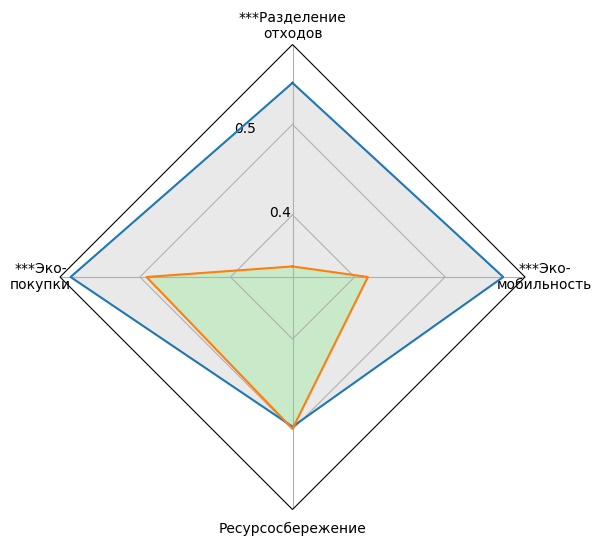

In [8]:
_l = ['Разделение\nотходов', 'Эко-\nпокупки', 'Ресурсосбережение', 'Эко-\nмобильность']
c_before = ['RB', 'ESB', 'RSB', 'EMB', ]
c_after = ['RBo', 'ESBo', 'RSBo', 'EMBo', ]
_sig = []
_c = []
_t = []
for i in range(len(c_before)):
    g = cg[[c_before[i], c_after[i]]].dropna()
    ctrl = g[c_before[i]]
    trtm = g[c_after[i]]
    m1 = bootstrap(ctrl)
    m2 = bootstrap(trtm)
    t, p = wilcoxon(trtm, ctrl)
    r = cohen_r(p, len(ctrl))  
    _sig.append(get_stars(p))  
    print(f'''{_l[i].strip()}
    Mdn_self({len(ctrl)})={m1[0]:.2f}, 95%CI†[{m1[0] - m1[1]:.2f}–{m1[0] + m1[1]:.2f}],
    Mdn_other({len(trtm)})={m2[0]:.2f}, 95%CI†[{m2[0] - m2[1]:.2f}–{m2[0] + m2[1]:.2f}],
    two-sided: W={t}, p={p:.3f}, r‡={r:.2f},
    ''')
    _c += [m1[0]]
    _t += [m2[0]]
print('Note. Null hypothesis H0: the median of the differences is located at zero.')
print('† Bootstrapped 95% confidence intervals for the median from 1000 resamples are reported.')
print('‡ Cohen’s r (Fritz et al., 2012; Cohen, 1988) for Wilcoxon signed-rank test is reported.')
# a large effect is .5, a medium effect is .3, and a small effect is .1 (Coolican, 2009, p. 395).

theta = radar_factory(len(_l), frame='polygon')
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_title('', position=(0.5, 1.1), ha='center')
_colors = ['silver', 'lightgreen']
for i, d_ in enumerate([_c, _t]):
    line = ax.plot(theta, d_)
    ax.fill(theta, d_, alpha=0.35, label='_nolegend_', color=_colors[i], edgecolor=_colors[i])
ax.set_varlabels([a + b for a,b in zip(_sig, _l)])
plt.show()

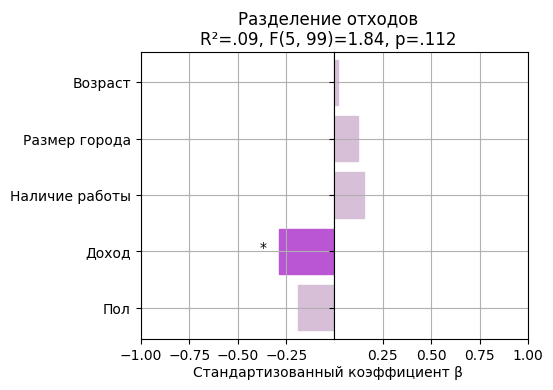

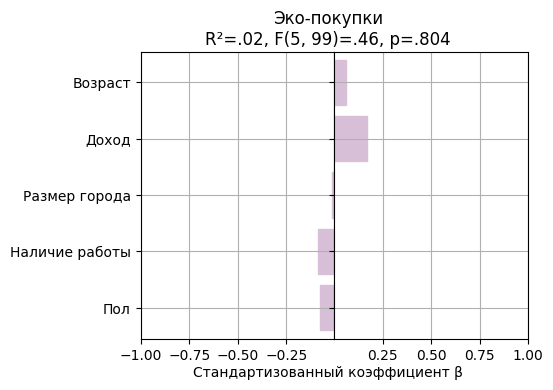

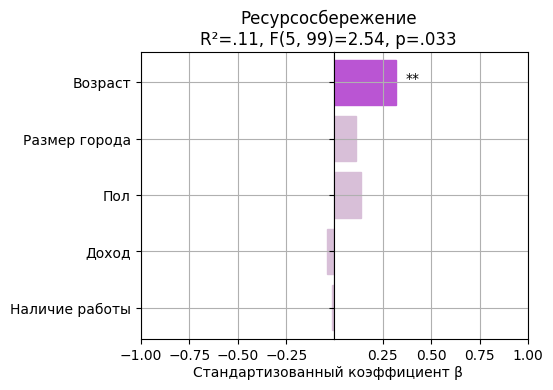

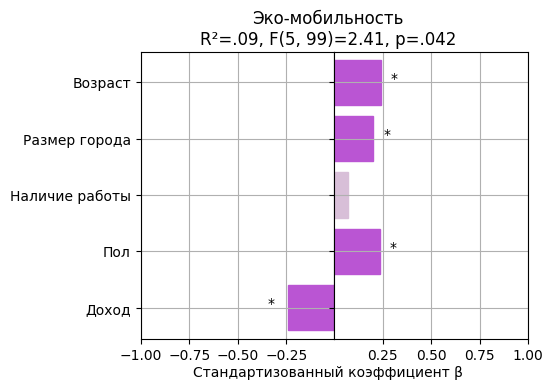

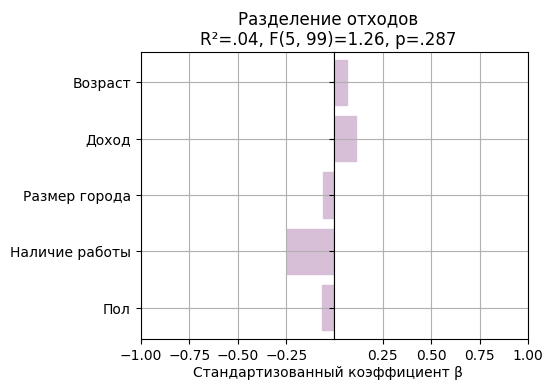

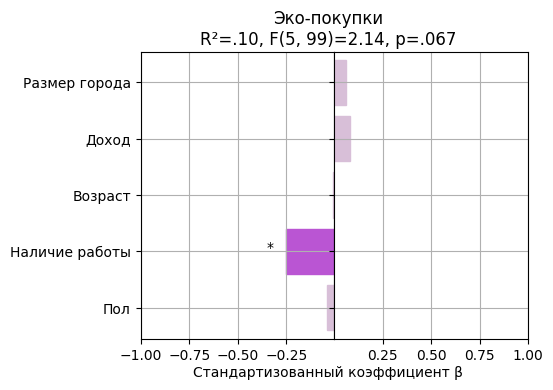

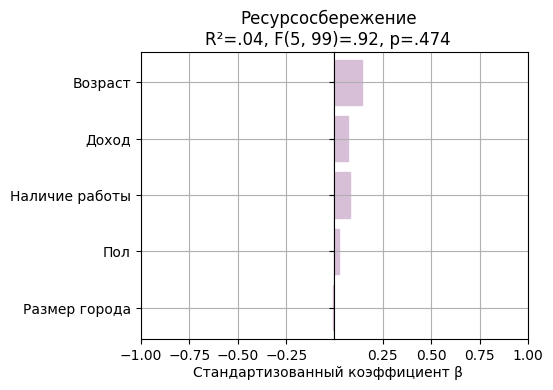

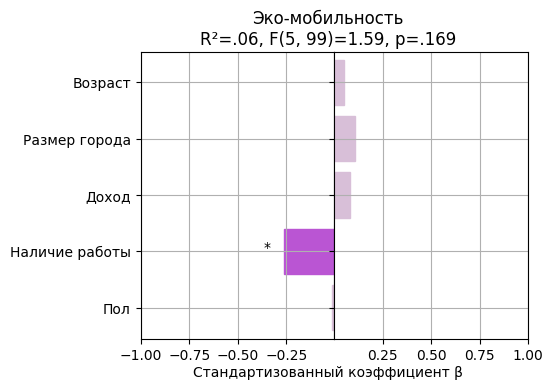

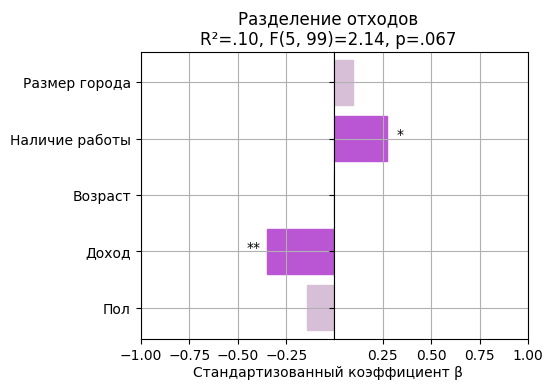

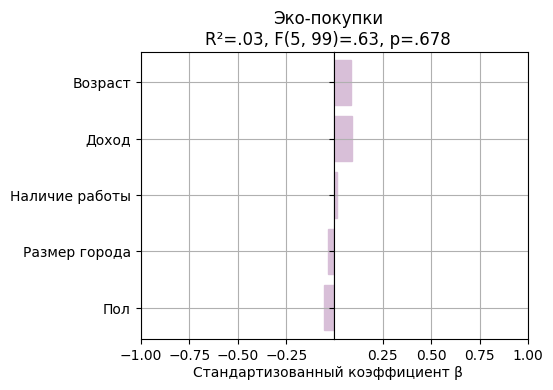

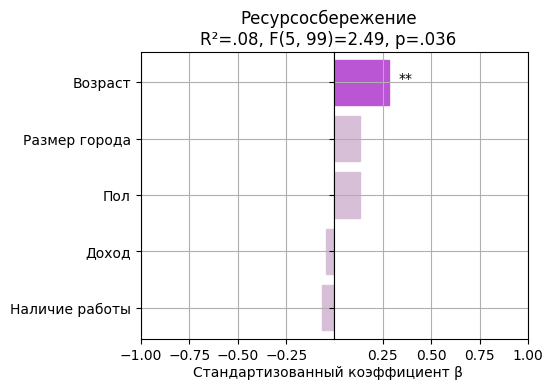

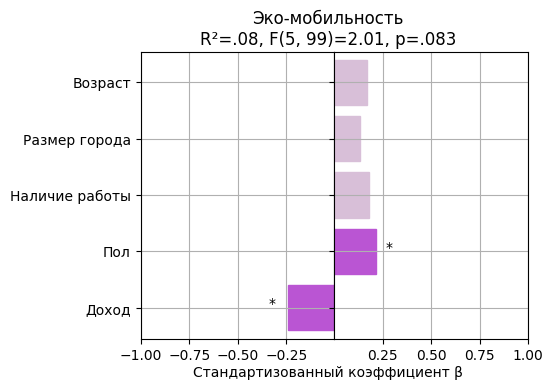

In [9]:
#RB – Recycling Behavior, ESB – Eco-Shopping Behavior, RSB – Resource-Saving Behavior, EMB – Eco-Mobility Behavior
_l = ['Разделение отходов', 'Эко-покупки', 'Ресурсосбережение', 'Эко-мобильность']
x = ['sex', 'age', 'income', 'isworking', 'city_size'] #'edu', 'car', 
y = ['RB', 'ESB', 'RSB', 'EMB', 'RBo', 'ESBo', 'RSBo', 'EMBo', 'RBd', 'ESBd', 'RSBd', 'EMBd']
_l = _l * 3
_d = cg.copy()[x+y]
results = []
ren = {'_c': 'Интервенция',
       'age': 'Возраст',
       'sex': 'Пол',
       'income': 'Доход',
       'edu': 'Образование',
       'isworking': 'Наличие работы',
       'car': 'Наличие машины',
       'city_size': 'Размер города',
       }
ren.update({k:v for k,v in zip(y, _l)})
for i in y:
    r = calc_OLS(_d, x, i)
    r[0].sort_values(by='feature', ascending=False, inplace=True)
    r[0]['feature'] = r[0]['feature'].apply(lambda x: ren[x] if x in ren else x)
    t = ren[i].replace('\n', ' ')+'\n'+r[1] if i in ren else i+'\n'+r[1]
    r = (r[0],f'{i}:{t}')
    results.append(r)
    fig = tree_graph(r[0], robust=True, title=t)
    fig.savefig(f'{i}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)

In [10]:
!rm fig.zip
!zip -r fig.zip *.png 

rm: cannot remove 'fig.zip': No such file or directory
  adding: EMBd.png (deflated 14%)
  adding: EMBo.png (deflated 15%)
  adding: EMB.png (deflated 14%)
  adding: ESBd.png (deflated 15%)
  adding: ESBo.png (deflated 14%)
  adding: ESB.png (deflated 14%)
  adding: RBd.png (deflated 14%)
  adding: RBo.png (deflated 14%)
  adding: RB.png (deflated 15%)
  adding: RSBd.png (deflated 14%)
  adding: RSBo.png (deflated 15%)
  adding: RSB.png (deflated 15%)


In [11]:
coef = []
_coef = None
for r in results:
  print(r[1])
  tmp = r[0][(r[0]['sig_robust'] != '') & (r[0]['sig_robust'] != '+')].copy()
  display(tmp)
  _coef = pd.concat([_coef, tmp], ignore_index=False)

RB:Разделение отходов
R²=.09, F(5, 99)=1.84, p=.112


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
2,income,Доход,-0.2876,0.124,-2.311,0.021,-0.532,-0.044,*,-0.2624,0.116,-2.256,0.024,-0.49,-0.034,*


ESB:Эко-покупки
R²=.02, F(5, 99)=.46, p=.804


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig


RSB:Ресурсосбережение
R²=.11, F(5, 99)=2.54, p=.033


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
1,age,Возраст,0.32,0.096,3.349,0.001,0.133,0.507,**,0.3589,0.11,3.257,0.001,0.143,0.575,**


EMB:Эко-мобильность
R²=.09, F(5, 99)=2.41, p=.042


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
0,sex,Пол,0.2365,0.105,2.254,0.024,0.031,0.442,*,0.1983,0.103,1.918,0.055,-0.004,0.401,
2,income,Доход,-0.2431,0.119,-2.044,0.041,-0.476,-0.010,*,-0.2050,0.122,-1.681,0.093,-0.444,0.034,
4,city_size,Размер города,0.2019,0.100,2.014,0.044,0.005,0.398,*,0.1568,0.089,1.758,0.079,-0.018,0.332,
1,age,Возраст,0.2388,0.108,2.213,0.027,0.027,0.450,*,0.2298,0.104,2.211,0.027,0.026,0.433,*


RBo:Разделение отходов
R²=.04, F(5, 99)=1.26, p=.287


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig


ESBo:Эко-покупки
R²=.10, F(5, 99)=2.14, p=.067


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
3,isworking,Наличие работы,-0.2486,0.098,-2.528,0.011,-0.441,-0.056,*,-0.3328,0.115,-2.887,0.004,-0.559,-0.107,**


RSBo:Ресурсосбережение
R²=.04, F(5, 99)=.92, p=.474


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig


EMBo:Эко-мобильность
R²=.06, F(5, 99)=1.59, p=.169


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
3,isworking,Наличие работы,-0.2631,0.122,-2.15,0.032,-0.503,-0.023,*,-0.2362,0.126,-1.878,0.06,-0.483,0.01,


RBd:Разделение отходов
R²=.10, F(5, 99)=2.14, p=.067


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
3,isworking,Наличие работы,0.2699,0.125,2.154,0.031,0.024,0.516,*,0.2290,0.104,2.197,0.028,0.025,0.433,*
2,income,Доход,-0.3514,0.124,-2.843,0.004,-0.594,-0.109,**,-0.2885,0.124,-2.318,0.020,-0.532,-0.045,*


ESBd:Эко-покупки
R²=.03, F(5, 99)=.63, p=.678


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig


RSBd:Ресурсосбережение
R²=.08, F(5, 99)=2.49, p=.036


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
1,age,Возраст,0.2828,0.099,2.859,0.004,0.089,0.477,**,0.3003,0.102,2.937,0.003,0.1,0.501,**


EMBd:Эко-мобильность
R²=.08, F(5, 99)=2.01, p=.083


,i,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
0,sex,Пол,0.2156,0.099,2.187,0.029,0.022,0.409,*,0.2017,0.102,1.978,0.048,0.002,0.402,*
2,income,Доход,-0.2387,0.112,-2.137,0.033,-0.458,-0.020,*,-0.2303,0.129,-1.789,0.074,-0.483,0.022,


In [12]:
_coef.coef.abs().mean()

0.24846153846153846

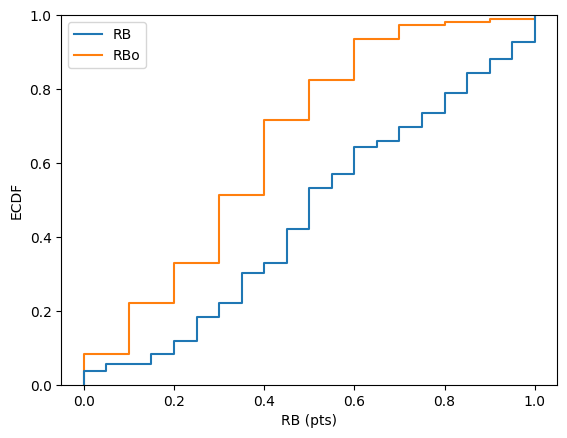

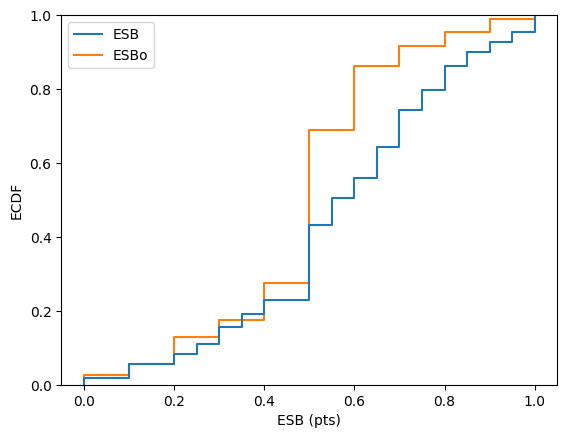

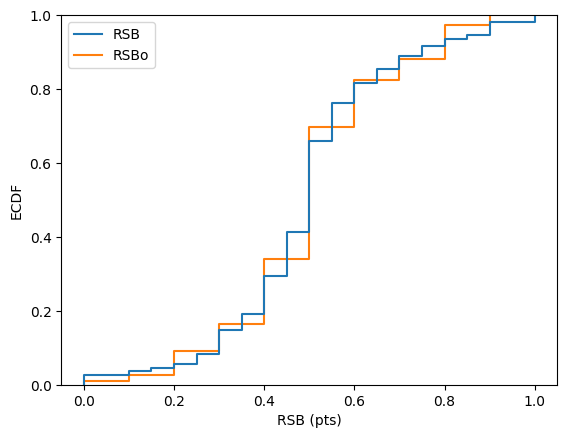

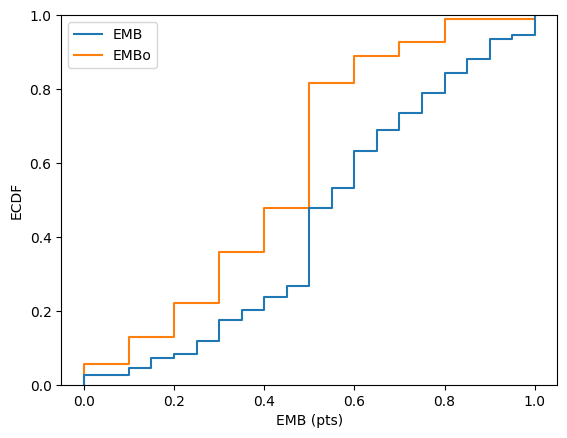

In [13]:
for c in ['RB', 'ESB', 'RSB', 'EMB']:
  _d = {c: cg[c], c+'o': cg[c+'o']} 
  plot_ecdf(_d, f'{c} (pts)')